In [2]:
import pandas as pd
import numpy as np

## get the stock data 

In [2]:
# get the stock data
from google.cloud import storage
def get_amazn_stock_data_from_gcp(nrows=10000, local=False, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/amazon_stock_price.csv"
    df = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    return df


In [3]:
df_stocks = get_amazn_stock_data_from_gcp(local = True)

In [4]:
df_stocks = df_stocks.sort_values(["date"], ascending=True)

In [5]:
df_stocks.head()

,date,AMZN
5551,1999-11-01,69.13
5550,1999-11-02,66.44
5549,1999-11-03,65.81
5548,1999-11-04,63.06
5547,1999-11-05,64.94


In [73]:
df_stocks.to_csv("df_stocks", index=False)

## get the sentiment data

In [6]:
# get the data from GCP
from google.cloud import storage
def get_sentiment_news_data_from_gcp(nrows=10000, local=False, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/final_stocks_sentiment.csv"
    df = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    return df

In [7]:
sentiment = get_sentiment_news_data_from_gcp()

In [8]:
sentiment = sentiment[['date', 'ticker', 'class_label']]

In [9]:
sentiment = sentiment.loc[sentiment['ticker'] == 'AMZN']

In [10]:
sentiment = sentiment.reset_index(drop=True)

In [11]:
sentiment = sentiment.drop(columns=['ticker'])


In [12]:
sentiment['date'] = pd.to_datetime(sentiment['date'], infer_datetime_format=True)

In [13]:
min_date = sentiment["date"].min()
min_date

Timestamp('2020-11-02 00:00:00')

In [14]:
sentiment.head()

,date,class_label
0,2020-11-02,0.000000
1,2020-11-05,1.000000
2,2020-11-06,0.333333
3,2020-11-07,1.000000
4,2020-11-09,0.250000


In [74]:
sentiment.to_csv("sentiment", index=False)

In [15]:
df_stocks = df_stocks[['date', 'AMZN']]
df_stocks["date"] = pd.to_datetime(df_stocks['date'], infer_datetime_format=True)

In [16]:
stock_df = df_stocks[df_stocks["date"]>= min_date]
stock_df

,date,AMZN
266,2020-11-02,3004.48
265,2020-11-03,3048.41
264,2020-11-04,3241.16
263,2020-11-05,3322.00
262,2020-11-06,3311.37
...,...,...
4,2021-11-16,3540.70
3,2021-11-17,3549.00
2,2021-11-18,3696.06
1,2021-11-19,3676.57


In [78]:
merged_df = pd.merge(stock_df, sentiment, on='date', how='outer')
merged_df.head()

,date,AMZN,class_label
0,2020-11-02,3004.48,0.000000
1,2020-11-03,3048.41,NaN
2,2020-11-04,3241.16,NaN
3,2020-11-05,3322.00,1.000000
4,2020-11-06,3311.37,0.333333


## Preprocess and merge data

In [98]:
merged_df.head()

,date,AMZN,class_label,twitter_label
0,2020-11-02,3004.48,0.000000,-1.0
1,2020-11-03,3048.41,-1.000000,-1.0
2,2020-11-04,3241.16,-1.000000,-1.0
3,2020-11-05,3322.00,1.000000,-1.0
4,2020-11-06,3311.37,0.333333,-1.0


In [12]:
merged_df.sort_values(by='date', ascending=True, inplace=True)

In [13]:
merged_df.reset_index(inplace=True, drop=True)

<AxesSubplot:>

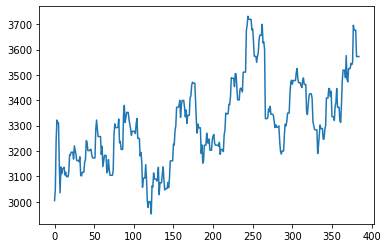

In [14]:
merged_df["AMZN"].plot()

<AxesSubplot:>

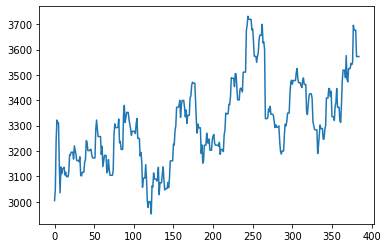

In [15]:
merged_df["AMZN"].interpolate(method='pad', limit=3).plot()

In [16]:
merged_df["AMZN"] = merged_df["AMZN"].interpolate(method='pad', limit=3)

In [97]:
merged_df.isna().sum()

date             0
AMZN             0
class_label      0
twitter_label    0
dtype: int64

In [17]:
merged_df.fillna(value=-1, inplace=True)

In [18]:
merged_df.to_csv("merged_df")

In [19]:
# @Davy start from this point!!!!!

In [11]:
merged_df = pd.read_csv("merged_twitter_df")

In [12]:
merged_df.head()

,date,AMZN,class_label,twitter_label
0,2020-11-02,3004.48,0.000000,-1.0
1,2020-11-03,3048.41,-1.000000,-1.0
2,2020-11-04,3241.16,-1.000000,-1.0
3,2020-11-05,3322.00,1.000000,-1.0
4,2020-11-06,3311.37,0.333333,-1.0


In [28]:
#put the data which dont have to be scaled in the index
# THERE IS NO NEED TO DO SO, YOU CAN SCALE A PARTICULAR COLUMN
# df_temp = merged_df.set_index(["date", "class_label"])
# df_temp = df_temp[["AMZN"]]
# df_temp.shape
# df_temp

### Scaling stocks

In [13]:
merged_df.columns

Index(['date', 'AMZN', 'class_label', 'twitter_label'], dtype='object')

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# INSTANTIATE THE SCALER
scaler = MinMaxScaler()

# FIT IT ONLY ON AMZN
scaler.fit(merged_df[['AMZN']])

# YOU NOW HAVE ACCESS TO THE MIN AND MAX OF AMZN
print(f"minimum value = {scaler.data_min_}")
print(f"maximum value = {scaler.data_max_}")

minimum value = [2951.95]
maximum value = [3731.41]


In [10]:
# LET'S CREATE A COPY OF MERGED_DF
data_scaled = merged_df.copy()

# AND TRANSFORM ONLY THE AMZN COLUMN
data_scaled["AMZN"] = scaler.transform(merged_df[['AMZN']])

# NOW LOOK AT DATA_SCALED
data_scaled.head(20)

,date,AMZN,class_label,twitter_label
0,2020-11-02,0.067393,0.000000,-1.0
1,2020-11-03,0.123752,-1.000000,-1.0
2,2020-11-04,0.371039,-1.000000,-1.0
3,2020-11-05,0.474752,1.000000,-1.0
4,2020-11-06,0.461114,0.333333,-1.0
5,2020-11-07,0.461114,1.000000,-1.0
6,2020-11-09,0.246055,0.250000,-1.0
7,2020-11-10,0.106574,1.000000,-1.0
8,2020-11-11,0.237908,0.000000,-1.0
9,2020-11-12,0.203128,1.000000,-1.0


In [8]:
# merged_df["AMZN"] = X_scaled_temp
# merged_df.head(20)


# df  = merged_df.copy()

# df.head()

## prepare it for model LSTM

In [16]:
# SETTING THE DATE AS INDEX
data_scaled.set_index(["date"], inplace= True)

KeyError: "None of ['date'] are in the columns"

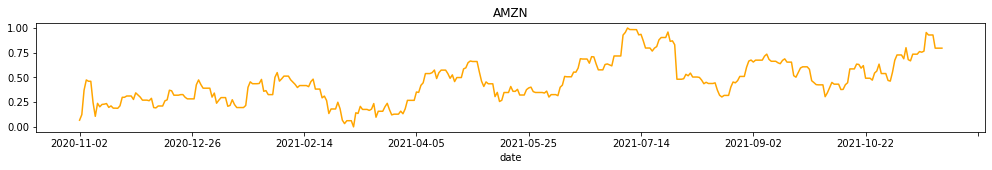

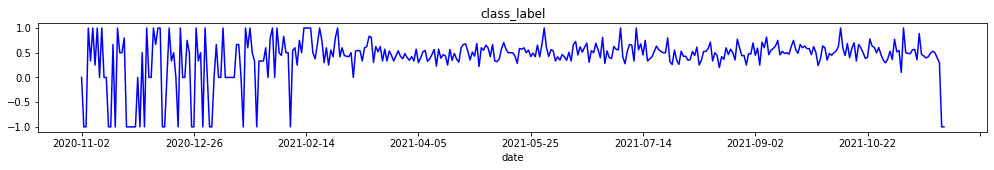

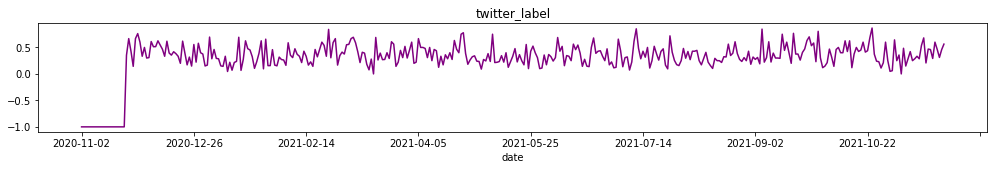

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

for column in data_scaled.columns:
    if column == "AMZN": color = "orange"
    if column == "class_label": color = "blue" 
    if column == "twitter_label": color = "purple" 
    data_scaled[column].plot(figsize=(17, 2), color=color)
    plt.title(column)
    plt.show()

In [18]:
data_scaled.describe()

,AMZN,class_label,twitter_label
count,385.000000,385.000000,385.000000
mean,0.459112,0.410457,0.294951
std,0.210588,0.434192,0.348702
min,0.000000,-1.000000,-1.000000
25%,0.305121,0.347826,0.222222
50%,0.438791,0.500000,0.333333
75%,0.595348,0.600000,0.463415
max,1.000000,1.000000,0.866667


X.shape = number of sequence?, 30, 2 <br>
y.shape = number of sequence?

In [22]:
import numpy as np

def subsample_sequence(df, length, HORIZON=0):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length+HORIZON]
    # X_sample = df_sample[random_start: random_start+length]
    # y_sample = df_sample[random_start + length:]
    return df_sample

In [23]:
subsample_sequence(data_scaled, 10)

,AMZN,class_label,twitter_label
date,,,
2021-07-22,0.880199,0.523810,0.425000
2021-07-23,0.904075,0.500000,0.473684
2021-07-24,0.904075,0.500000,0.166667
2021-07-25,0.904075,0.800000,0.095238
2021-07-26,0.959472,0.317073,0.718750
2021-07-27,0.865266,0.260870,0.410256
2021-07-28,0.870308,0.551724,0.254545
2021-07-29,0.831306,0.348837,0.174757
2021-07-30,0.481923,0.264706,0.157407


In [24]:
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''

    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -1]['AMZN'] # -1 means the future window
    
    X_sample = df_subsample[0:length -1]# -1 means the future window
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [25]:
split_subsample_sequence(data_scaled, 10)

(array([[0.50418238, 0.44444444, 0.42857143],
        [0.50418238, 0.61538462, 0.44444444],
        [0.50418238, 0.25      , 0.25      ],
        [0.50024376, 0.34782609, 0.17142857],
        [0.47305827, 0.52631579, 0.29032258],
        [0.43640469, 0.52631579, 0.40740741],
        [0.45101737, 0.58333333, 0.22222222],
        [0.43879096, 0.71428571, 0.15789474],
        [0.43879096, 0.33333333, 0.10344828]]),
 array(0.43879096))

In [26]:
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['AMZN']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

In [27]:
(X_sample, y_sample) = split_subsample_sequence(data_scaled, 10)

In [28]:
(X_sample, y_sample)

(array([[0.68630847, 0.61290323, 0.27586207],
        [0.68630847, 0.69230769, 0.14583333],
        [0.68630847, 0.30769231, 0.13793103],
        [0.64404844, 0.54320988, 0.5       ],
        [0.71009417, 0.5       , 0.67857143],
        [0.70801581, 0.69090909, 0.38888889],
        [0.6377877 , 0.55932203, 0.42857143],
        [0.57669412, 0.4       , 0.4375    ],
        [0.57669412, 0.8125    , 0.33333333]]),
 array(0.57669412))

In [29]:
X_sample.shape, y_sample.shape

((9, 3), ())

In [30]:
def get_X_y(df, n_sequences, length): #length = 30, n_sequence = 12, df(12month)
    '''Return a list of samples (X, y)'''
    
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

In [31]:
##TESTING THE GET X Y FUNCTION

df = data_scaled
n_sequences = 7
length = 30

X, y = get_X_y(df, n_sequences, length)

In [32]:
X.shape, y.shape

((7, 29, 3), (7,))

In [33]:
# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(12, figsize=[20,100])
# # fig.suptitle('Vertically stacked subplots')

# for i in range(len(df_list[0])):
#     axs[i].plot(df_list[0][i])

## Train test split

In [34]:
# len of train dataset should be 80%

In [35]:
len_ = int(0.8*data_scaled.shape[0])
df_train = data_scaled[:len_]
df_test = data_scaled[len_:]
print(df_train.shape)
print(df_test.shape)

(308, 3)
(77, 3)


In [36]:
X_train, y_train = get_X_y(df_train, 200, 30) # 200 sequences of a length of 30 days
X_test, y_test = get_X_y(df_test, 100, 30) # 200 sequences of a length of 30 days

In [37]:
X_train.shape, y_train.shape

((200, 29, 3), (200,))

In [38]:
X_test.shape, y_test.shape

((100, 29, 3), (100,))

## predict a baseline

In [39]:
# We here decide to predict the mean of the train set y_train
y_pred = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 27 %


In [40]:
# Or (better) we predict the last pollution value!
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 7 %


## Imports for model


In [41]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2021-12-01 15:20:14.536255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 15:20:14.536402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## simple LSTM

In [42]:
def init_model():
    
    # Metrics and optimizers
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)
    
    # Architecture
    
    ## Initialising
    model = models.Sequential()
    
    ## LSTM layer
    model.add(layers.LSTM(20, activation='tanh'))
    
    ## Hidden Dense Layer
    model.add(layers.Dense(5, activation='relu'))
    
    ## Predictive layer : only one neuron because we are predicting the NEXT POINT
    model.add(layers.Dense(1, activation='linear')) # REPLACE 1 WITH HORIZON
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [43]:
model = init_model()

2021-12-01 15:20:21.232845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-01 15:20:21.233019: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 15:20:21.233088: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-47G28MR): /proc/driver/nvidia/version does not exist
2021-12-01 15:20:21.233888: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
number_of_rows = len(X_train)
validation_split = 0.2

In [45]:
#number of rows in train
number_of_rows_train_train = number_of_rows * (1 - validation_split)
number_of_rows_train_train

160.0

In [46]:
#number of epochs
np.ceil(160/64)

3.0

In [47]:
batch_size = 64
number_of_iterations_per_epoch = int(np.ceil(len(X_train) / batch_size * (1-validation_split)))
number_of_iterations_per_epoch

3

In [48]:
es = EarlyStopping(monitor ='val_loss',
                   patience=10,
                   restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs=2, 
                    batch_size=64,
                    # callbacks=[es],
                    verbose=1)

Epoch 1/2
3/3 [==============================] - 11s 1s/step - loss: 0.3046 - mean_absolute_percentage_error: 131.5112 - val_loss: 0.0219 - val_mean_absolute_percentage_error: 52.4705
Epoch 2/2
3/3 [==============================] - 0s 161ms/step - loss: 0.0224 - mean_absolute_percentage_error: 47.4630 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 40.9202


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1920      
                                                                 
 dense (Dense)               (None, 5)                 105       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2,031
Trainable params: 2,031
Non-trainable params: 0
_________________________________________________________________


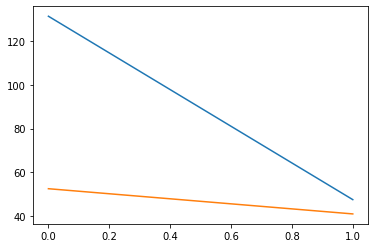

In [50]:
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])

In [51]:
res = model.evaluate(X_test, y_test, verbose=1)

print(f'MAPE on the test set : {res[1]:.0f} %')

4/4 [==============================] - 0s 37ms/step - loss: 0.0320 - mean_absolute_percentage_error: 19.7073
MAPE on the test set : 20 %


## Improved Model

In [52]:
def init_model_2():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.005)
    
    model = models.Sequential()
    
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [53]:
model_2 = init_model_2()

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train,
            validation_split=0.3,
            epochs=5, 
            batch_size=32,
            callbacks=[es], verbose=1)

Epoch 1/5
5/5 [==============================] - 19s 1s/step - loss: 0.1170 - mean_absolute_percentage_error: 87.9702 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 48.9054
Epoch 2/5
5/5 [==============================] - 1s 233ms/step - loss: 0.0250 - mean_absolute_percentage_error: 49.4600 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 43.2140
Epoch 3/5
5/5 [==============================] - 1s 253ms/step - loss: 0.0190 - mean_absolute_percentage_error: 41.9379 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 38.8840
Epoch 4/5
5/5 [==============================] - 1s 242ms/step - loss: 0.0255 - mean_absolute_percentage_error: 43.3306 - val_loss: 0.0399 - val_mean_absolute_percentage_error: 36.6654
Epoch 5/5
5/5 [==============================] - 1s 238ms/step - loss: 0.0229 - mean_absolute_percentage_error: 42.4100 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 30.6028


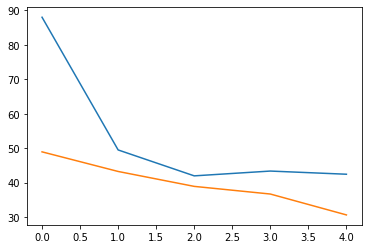

In [54]:
import matplotlib.pyplot as plt
plt.plot(history_2.history['mean_absolute_percentage_error'])
plt.plot(history_2.history['val_mean_absolute_percentage_error'])

In [55]:
res = model_2.evaluate(X_test, y_test, verbose=1)

print(f'MAPE on the test set : {res[1]:.0f} %')

4/4 [==============================] - 0s 63ms/step - loss: 0.0326 - mean_absolute_percentage_error: 20.9842
MAPE on the test set : 21 %


In [56]:
X_test.shape, y_test.shape

((100, 29, 3), (100,))

In [57]:
predictions_2 = model_2.predict(X_test)
predictions_2.shape

(100, 1)

In [58]:
unscaled_predictions_2 = scaler.inverse_transform(predictions_2)
unscaled_predictions_2[0:10] # showing 10 predictions in the test set out of 100 

array([[3265.6296],
       [3248.452 ],
       [3313.2808],
       [3385.4119],
       [3250.6675],
       [3315.1252],
       [3369.8047],
       [3391.695 ],
       [3323.4495],
       [3419.838 ]], dtype=float32)

In [60]:
y_test.reshape(-1,1).shape

(100, 1)

In [76]:
X, y = get_X_y(df, len(df), 30)

In [77]:
X.shape, y.shape

((385, 29, 3), (385,))

In [78]:
predictions_X = model_2.predict(X)
predictions_X[:10]

array([[0.3691427 ],
       [0.4590493 ],
       [0.36217627],
       [0.4535021 ],
       [0.43706188],
       [0.647418  ],
       [0.2351782 ],
       [0.36017302],
       [0.47573406],
       [0.26065588]], dtype=float32)

In [79]:
unscaled_predictions_X = scaler.inverse_transform(predictions_X)
unscaled_predictions_X[:10]

array([[3239.682 ],
       [3309.7605],
       [3234.2517],
       [3305.4368],
       [3292.6223],
       [3456.5864],
       [3135.262 ],
       [3232.6904],
       [3322.7656],
       [3155.1208]], dtype=float32)

,AMZN
0,3004.48
1,3048.41
2,3241.16
3,3322.00
4,3311.37
...,...
380,3676.57
381,3572.57
382,3572.57
383,3572.57


In [89]:

df_true_pred = merged_df[["date", "AMZN"]]
df_true_pred["predictions"]=unscaled_predictions_X


/tmp/ipykernel_3117/1919949454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_pred["predictions"]=unscaled_predictions_X


In [92]:
df_true_pred.head()

,date,AMZN,predictions,ticker
0,2020-11-02,3004.48,3239.681885,AMZN
1,2020-11-03,3048.41,3309.760498,AMZN
2,2020-11-04,3241.16,3234.251709,AMZN
3,2020-11-05,3322.00,3305.436768,AMZN
4,2020-11-06,3311.37,3292.622314,AMZN


<AxesSubplot:>

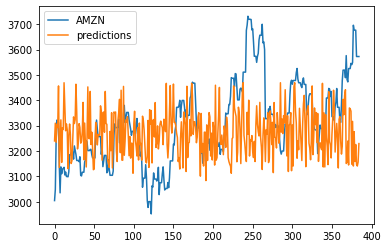

In [94]:
df_true_pred.plot()

In [91]:
df_true_pred["ticker"] = "AMZN"

In [93]:
df_true_pred.to_csv("LSTM_3features_AMZN")

## Check Performance of the models

In [61]:
def train_model(nb_sequences=200, nb_days=30, plot_history=True,epochs = 10):
    
    X_train, y_train = get_X_y(df_train, nb_sequences, nb_days)
    X_test, y_test = get_X_y(df_test, round(nb_sequences/2), nb_days)

    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)

    model = models.Sequential()
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])


    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
            validation_split=0.3,
            epochs=epochs, 
            batch_size=32,
            callbacks=[es],
            verbose=1)

    if plot_history:
        plt.plot(history.history['mean_absolute_percentage_error'])
        plt.plot(history.history['val_mean_absolute_percentage_error'])
        plt.show()

    res = model.evaluate(X_test, y_test, verbose=1)
    print(f'MAPE on the test set : {res[1]:.0f} %')
    return res

Epoch 1/10
5/5 [==============================] - 5s 222ms/step - loss: 0.1355 - mean_absolute_percentage_error: 78.1527 - val_loss: 0.0418 - val_mean_absolute_percentage_error: 58.2556
Epoch 2/10
5/5 [==============================] - 0s 27ms/step - loss: 0.0395 - mean_absolute_percentage_error: 47.9022 - val_loss: 0.0566 - val_mean_absolute_percentage_error: 78.4917
Epoch 3/10
5/5 [==============================] - 0s 28ms/step - loss: 0.0440 - mean_absolute_percentage_error: 50.2554 - val_loss: 0.0459 - val_mean_absolute_percentage_error: 32.5050
Epoch 4/10
5/5 [==============================] - 0s 30ms/step - loss: 0.0402 - mean_absolute_percentage_error: 45.7380 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 24.1609
Epoch 5/10
5/5 [==============================] - 0s 28ms/step - loss: 0.0338 - mean_absolute_percentage_error: 35.2720 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 48.8844
Epoch 6/10
5/5 [==============================] - 0s 31ms/step - loss: 0.0

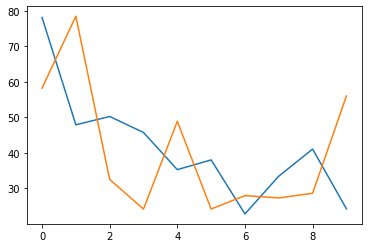

4/4 [==============================] - 0s 4ms/step - loss: 0.0487 - mean_absolute_percentage_error: 33.6792
MAPE on the test set : 34 %


[0.048741456121206284, 33.679195404052734]

In [140]:
train_model(nb_sequences=200, nb_days=30, plot_history=True)

## manual Grid Search LSTM

In [ ]:
nb_days_grid = [12,30,60]
nb_sequences_grid = [12, 50, 100]
MAPE = []

In [ ]:
for nb_days in nb_days_grid:
    for nb_sequences in nb_sequences_grid:
        res = train_model(nb_sequences=nb_sequences, nb_days=nb_days)
        MAPE.append((nb_days, nb_sequences, res[1]))
        print(f'For {nb_sequences} sequences and {nb_days} days of observation, the MAPE is of {res[1]:.0f} %')

In [ ]:
MAPE

In [ ]:
import matplotlib
x = [res[0] for res in MAPE] # n_days
y = [res[1] for res in MAPE] # n_seq
c = [res[2] for res in MAPE] # MAPE  
plt.scatter(x, y, c=c, norm=matplotlib.colors.Normalize(clip=False), cmap='coolwarm') # vmin=20, vmax=50, 

In [ ]:
# sns.heatmap(data= x, y, c=c)

## Test LSTM with prediction

In [69]:
def train_model_predict(nb_sequences=12, nb_days=30, plot_history=False):
    X_train, y_train = get_X_y(df_train, nb_sequences, nb_days)
    X_test, y_test = get_X_y(df_test, round(nb_sequences*0.2), nb_days)

    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)

    model = models.Sequential()
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])


    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
            validation_split=0.3,
            epochs=1000, 
            batch_size=64,
            callbacks=[es],
            verbose=0)

    if plot_history:
        plt.plot(history.history['mean_absolute_percentage_error'])
        plt.plot(history.history['val_mean_absolute_percentage_error'])
        plt.show()

    res = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    return res, y_pred

In [70]:
result = train_model_predict(nb_sequences=12, nb_days=30, plot_history=False)


In [71]:
result

([0.05257798358798027, 29.545623779296875],
 array([[0.45786142],
        [0.5031962 ]], dtype=float32))

In [72]:
result_1  = result[1][0]
result_1 = result_1.reshape(-1, 1)

In [ ]:
y_pred = scaler.inverse_transform(result_1)

In [ ]:
y_pred[0][0]

In [ ]:
scaler.inverse_transform(X_test[0])

In [ ]:
scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
def train_model_predict(nb_sequences=12, nb_days=30, plot_history=False):
    X_train, y_train = get_X_y(df_train, nb_sequences, nb_days)
    X_test, y_test = get_X_y(df_test, round(nb_sequences*0.2), nb_days)

    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)

    model = models.Sequential()
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])


    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
            validation_split=0.3,
            epochs=1000, 
            batch_size=64,
            callbacks=[es],
            verbose=0)

    if plot_history:
        plt.plot(history.history['mean_absolute_percentage_error'])
        plt.plot(history.history['val_mean_absolute_percentage_error'])
        plt.show()

    return model

model = train_model_predict(X_test)

In [ ]:
X_test

## Plot the results

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_test_transformed, color = 'black', label = 'AMZN Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AMZN Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Stock Price')
plt.legend()
plt.show()